File directory path  
               
````bash
aiffel
└── camera_sticker
    ├── project06.ipynb   <─ I am here
    ├── models
    │   └── shape_predictor_68_face_landmarks.dat
    └── images
        ├── cat-whiskers.png
        ├── woman_image.jpg
        └── image.png
````


주요 라이브러리 버전
```python
cv2.__version__  : 4.5.3
dlib.__version__ : 19.22.1
```

In [1]:
# 필요한 패키지 import
import os
import cv2
import matplotlib.pyplot as plt
import numpy as np
import dlib

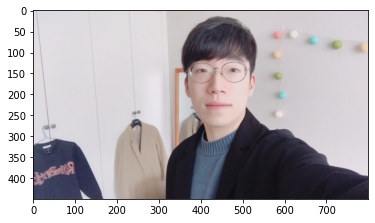

In [2]:
# (상대경로) images폴더 내 image.png 파일
my_image_path = 'images/image.png'
img_ori_bgr = cv2.imread(my_image_path)
# OpenCV는 BGR채널 이므로 RGB채널로 변경해줄 필요가 있음
# cv2에서 사용할 RGB 컬러 이미지 "img_rgb"
img_ori_rgb = cv2.cvtColor(img_ori_bgr, cv2.COLOR_BGR2RGB)
img_copy_rgb = img_ori_rgb.copy()
plt.imshow(img_ori_rgb)
plt.show()

In [3]:
# 얼굴 좌표와 얼굴 랜드마크를 찾는 함수
def face_detect(img):
    face_detector = dlib.get_frontal_face_detector()
    face_landmark_preditor = dlib.shape_predictor('models/shape_predictor_68_face_landmarks.dat')

    # 원본 이미지를 덮어쓰지 않기 위해 내부에서 사용할 변수로 재지정
    _img = img.copy()
    # Hog형태로 변환 후 얼굴 찾기
    dlib_rects = face_detector(_img, 1)
    
    # 얼굴을 찾은 후 사각형으로 위치 찾기
    _face_loc = []
    for dlib_rect in dlib_rects:
        l = dlib_rect.left() # 왼쪽
        t = dlib_rect.top() # 위쪽
        r = dlib_rect.right() # 오른쪽
        b = dlib_rect.bottom() # 아래쪽
        w = dlib_rect.width() # 사각형 가로
        h = dlib_rect.height() # 사각형 높이
        
        _face_loc.append(tuple([l, t, r, b, w, h]))
    # 얼굴 랜드마크 찾기
    _landmark_loc = []
    for land_mark in dlib_rects:
        points = face_landmark_preditor(_img, land_mark)
        #모든 landmark 위치정보를 (x, y) 형태로 변환하여 points 변수에 저장
        list_points = tuple(map(lambda p: (p.x, p.y), points.parts()))
                           
        _landmark_loc.append(list_points)
        
    return list(zip(_face_loc, _landmark_loc))

In [4]:
def put_sticker(img):
    sticker_path = 'images/cat-whiskers.png'
    img_sticker = cv2.imread(sticker_path)

    _img = img.copy()
    
    for i, face_info in enumerate(zip(face_detect(_img))):
        # face_info[i][0]: i번째 얼굴의 얼굴 위치 정보 tuple(l, t, r, b, w, h)
        # face_info[i][1]: i번째 얼굴의 68개 랜드마크 정보 tuple((x0, y0), (x1, y1), ..., (x67, y67)))
        
        # 스티커의 초기 위치(좌상단 기준)
        x = face_info[i][1][30][0]
        y = face_info[i][1][30][1]
        w = h = face_info[i][0][5] #얼굴 rectangle의 가로길이
    
        # img_sticker.shape : (y, x, rgb channel)으로 (187, 187, 3)꼴을 갖음
        img_sticker = cv2.resize(img_sticker, (w, h))
        
        refined_x = x - w // 2
        refined_y = y - h // 2
        
        # sticker crop부분
        if refined_x < 0:
            img_sticker = img_sticker[:, -refined_x]
            refined_x = 0
        if refined_y < 0:
            img_sticker = img_sticker[-refined_y:, :]
            refined_y = 0
        
        sticker_area = _img[refined_y:refined_y+img_sticker.shape[0], refined_x:refined_x+img_sticker.shape[1]]
        
        dst = cv2.addWeighted(sticker_area, 0.3, img_sticker, 0.8, 0)
        
        # _img[row범위,col범위] = img_sticker의 값이 0이면, 합성 dst를 아니면 _img
        _img[refined_y:refined_y+img_sticker.shape[0], refined_x:refined_x+img_sticker.shape[1]] = \
    np.where(img_sticker==0,dst,sticker_area).astype(np.uint8)
        
        
    return cv2.cvtColor(_img, cv2.COLOR_BGR2RGB)


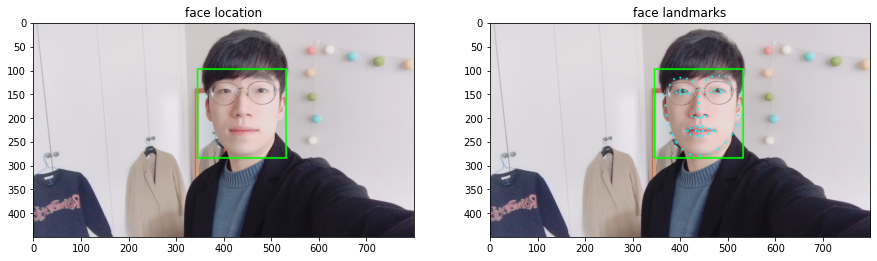

In [5]:
# 얼굴 및 랜드마크 출력
my_image_path = 'images/image.png'
img_ori_bgr = cv2.imread(my_image_path)

output = face_detect(cv2.cvtColor(img_ori_bgr, cv2.COLOR_BGR2RGB))

_img_ori_rgb = cv2.cvtColor(img_ori_bgr, cv2.COLOR_BGR2RGB)

cv2.rectangle(_img_ori_rgb, (output[0][0][0], output[0][0][1]), (output[0][0][2],output[0][0][3]), (0, 255, 0), 2, lineType=cv2.LINE_AA)

plt.figure(figsize=(15,15))
plt.subplot(1, 2, 1).set_title("face location")
plt.imshow(_img_ori_rgb)

points = output[0][1]
for point in points:
    cv2.circle(_img_ori_rgb, point, 2, (0, 255, 255), -1)

plt.subplot(1, 2, 2).set_title("face landmarks")
plt.imshow(_img_ori_rgb)
plt.show()   


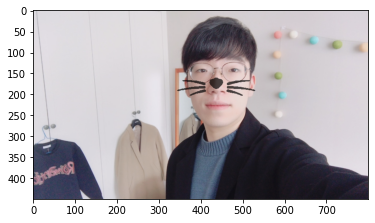

In [6]:
# 스티커 적용
my_image_path = 'images/image.png'
img_ori_bgr = cv2.imread(my_image_path)

plt.imshow(cv2.cvtColor(put_sticker(img_ori_rgb), cv2.COLOR_BGR2RGB))
plt.show()

### 스티커 작동 확인 사항

## 01. 얼굴의 각도 및 얼굴 크기(거리)

````bash
aiffel
└── camera_sticker
    ├── project06.ipynb   <─ I am here
    ├── models
    │   └── shape_predictor_68_face_landmarks.dat
    └── images
        ├── cat-whiskers.png
        ├── woman_image.jpg
        ├── tilthead.jpg        
        └── image.png
````

<img src = "https://media.istockphoto.com/id/529053936/photo/lovely-short-hair-brunette-smiling-at-camera-with-tilted-head.jpg?s=612x612&w=0&k=20&c=alGgCGajjxVN2FOxxq5gQIExuDeCwa4ihpYysF4AX0I=" width="30%" height="30%" title="출처: 구글 이미지 검색"/>

<img src = "https://1.bp.blogspot.com/-RkN4oNa0PGw/VktBx9nHMfI/AAAAAAAABkE/TzBdIdLXx30/s1600/tilthead.jpg" width="30%" height="30%" title="출처: 구글 이미지 검색"/>                                                                                                                                   
                                                                                                                                   
출처 : 구글 이미지 검색

In [7]:
from math import atan2, degrees

In [8]:
def angle(point_1, point_2):
    xdiff = point_2[0] - point_1[0]
    ydiff = point_2[1] - point_1[1]
    
    return degrees(atan2(ydiff,xdiff))

In [9]:
def transpose_put_sticker(img):
    sticker_path = 'images/cat-whiskers.png'
    img_sticker = cv2.imread(sticker_path)

    _img = img.copy()

    
    for i, face_info in enumerate(zip(face_detect(_img))):
        # face_info[i][0]: i번째 얼굴의 얼굴 위치 정보 tuple(l, t, r, b, w, h)
        # face_info[i][1]: i번째 얼굴의 68개 랜드마크 정보 tuple((x0, y0), (x1, y1), ..., (x67, y67)))
        _angle = -angle(face_info[i][1][2], face_info[i][1][14])
        m = cv2.getRotationMatrix2D((face_info[i][0][4]//2,face_info[i][0][5]//2), _angle, 1)        

        
        # 스티커의 초기 위치(좌상단 기준)
        x = face_info[i][1][30][0] # 코의 x좌표
        y = face_info[i][1][30][1] # 코의 y좌표
        w = h = face_info[i][0][4] #얼굴 rectangle의 가로길이
    
        # img_sticker.shape : (y, x, rgb channel)으로 (187, 187, 3)꼴을 갖음
        img_sticker = cv2.resize(img_sticker, (w, h))
        refined_x = x - h // 2
        refined_y = y - w // 2
        
        # sticker crop부분
        if refined_x < 0:
            img_sticker = img_sticker[:, -refined_x]
            refined_x = 0
        if refined_y < 0:
            img_sticker = img_sticker[-refined_y:, :]
            refined_y = 0
        
        sticker_area = _img[refined_y:refined_y+img_sticker.shape[0], refined_x:refined_x+img_sticker.shape[1]]
        
        rotated_sticker = cv2.warpAffine(img_sticker, m, (h, w), flags=cv2.INTER_LINEAR,borderValue=(255,255,255))  
        
        
        dst = cv2.addWeighted(sticker_area, 0.3, rotated_sticker, 0.8, 0)
        
        # _img[row범위,col범위] = img_sticker의 값이 0이면, 합성 dst를 아니면 _img
        _img[refined_y:refined_y+img_sticker.shape[0], refined_x:refined_x+img_sticker.shape[1]] = \
    np.where(rotated_sticker==0,dst,sticker_area).astype(np.uint8)
        
        
    return cv2.cvtColor(_img, cv2.COLOR_BGR2RGB)


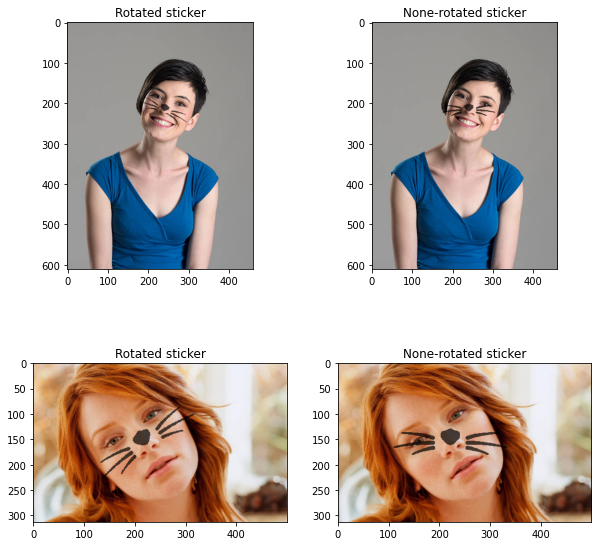

In [10]:
img_ori_bgr = cv2.imread('images/woman_image.jpg')
img_ori_rgb = cv2.cvtColor(img_ori_bgr, cv2.COLOR_BGR2RGB)

plt.figure(figsize=(10,10))
plt.subplot(2,2,1).set_title("Rotated sticker")
plt.imshow(cv2.cvtColor(transpose_put_sticker(img_ori_rgb), cv2.COLOR_BGR2RGB))

plt.subplot(2,2,2).set_title("None-rotated sticker")
plt.imshow(cv2.cvtColor(put_sticker(img_ori_rgb), cv2.COLOR_BGR2RGB))

img_ori_bgr = cv2.imread('images/tilthead.jpg')
img_ori_rgb = cv2.cvtColor(img_ori_bgr, cv2.COLOR_BGR2RGB)
plt.subplot(2,2,3).set_title("Rotated sticker")
plt.imshow(cv2.cvtColor(transpose_put_sticker(img_ori_rgb), cv2.COLOR_BGR2RGB))

plt.subplot(2,2,4).set_title("None-rotated sticker")
plt.imshow(cv2.cvtColor(put_sticker(img_ori_rgb), cv2.COLOR_BGR2RGB))
plt.show()

### 스티커 작동 확인 사항

## 02. 이미지의 밝기
````bash
aiffel
└── camera_sticker
    ├── project06.ipynb   <─ I am here
    ├── models
    │   └── shape_predictor_68_face_landmarks.dat
    └── images
        ├── cat-whiskers.png
        ├── woman_image.jpg
        ├── timcook_p120.jpg <─ brightness 120% up      
        ├── timcook_p80.jpg  <─ brightness 80% up
        ├── timcook_p60.jpg  <─ brightness 60% up   
        ├── timcook_0.jpg    <─ original image 
        ├── timcook_m60.jpg  <─ brightness 60% down   
        ├── timcook_m80.jpg  <─ brightness 80% down   
        ├── timcook_m120.jpg <─ brightness 120% down   
        └── image.png
````

<img src = "https://s3.orbi.kr/data/file/united2/3d91be51e50d4921b7d550ec4b28082e.jpg" width="30%" height="30%" title="출처: 구글 이미지 검색"/>

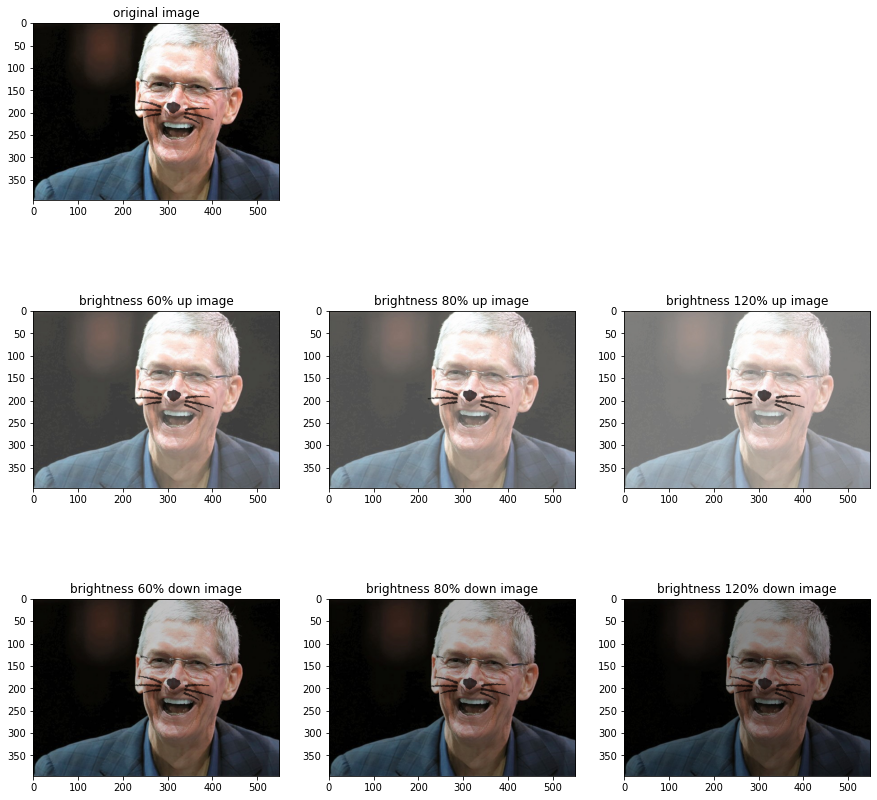

In [11]:
plt.figure(figsize=(15,15))

img_ori_bgr = cv2.imread('images/timcook_0.jpg')
img_ori_rgb = cv2.cvtColor(img_ori_bgr, cv2.COLOR_BGR2RGB)
plt.subplot(3,3,1).set_title("original image")
plt.imshow(cv2.cvtColor(transpose_put_sticker(img_ori_rgb), cv2.COLOR_BGR2RGB))

img_ori_bgr = cv2.imread('images/timcook_p60.jpg')
img_ori_rgb = cv2.cvtColor(img_ori_bgr, cv2.COLOR_BGR2RGB)
plt.subplot(3,3,4).set_title("brightness 60% up image")
plt.imshow(cv2.cvtColor(transpose_put_sticker(img_ori_rgb), cv2.COLOR_BGR2RGB))

img_ori_bgr = cv2.imread('images/timcook_p80.jpg')
img_ori_rgb = cv2.cvtColor(img_ori_bgr, cv2.COLOR_BGR2RGB)
plt.subplot(3,3,5).set_title("brightness 80% up image")
plt.imshow(cv2.cvtColor(transpose_put_sticker(img_ori_rgb), cv2.COLOR_BGR2RGB))

img_ori_bgr = cv2.imread('images/timcook_p120.jpg')
img_ori_rgb = cv2.cvtColor(img_ori_bgr, cv2.COLOR_BGR2RGB)
plt.subplot(3,3,6).set_title("brightness 120% up image")
plt.imshow(cv2.cvtColor(transpose_put_sticker(img_ori_rgb), cv2.COLOR_BGR2RGB))

img_ori_bgr = cv2.imread('images/timcook_m60.jpg')
img_ori_rgb = cv2.cvtColor(img_ori_bgr, cv2.COLOR_BGR2RGB)
plt.subplot(3,3,7).set_title("brightness 60% down image")
plt.imshow(cv2.cvtColor(transpose_put_sticker(img_ori_rgb), cv2.COLOR_BGR2RGB))

img_ori_bgr = cv2.imread('images/timcook_m80.jpg')
img_ori_rgb = cv2.cvtColor(img_ori_bgr, cv2.COLOR_BGR2RGB)
plt.subplot(3,3,8).set_title("brightness 80% down image")
plt.imshow(cv2.cvtColor(transpose_put_sticker(img_ori_rgb), cv2.COLOR_BGR2RGB))

img_ori_bgr = cv2.imread('images/timcook_m120.jpg')
img_ori_rgb = cv2.cvtColor(img_ori_bgr, cv2.COLOR_BGR2RGB)
plt.subplot(3,3,9).set_title("brightness 120% down image")
plt.imshow(cv2.cvtColor(transpose_put_sticker(img_ori_rgb), cv2.COLOR_BGR2RGB))

plt.show()